In [1]:
from data.utils import ColorBackgroundRGBA, ToRGB, BackgroundRemoval, CropForegroundRGBA
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as F
import numpy as np
import model.bootpig_unet as bootpig_unet # BootPIGUNet,StableDiffusionBootPIGPipeline
from diffusers import UniPCMultistepScheduler, StableDiffusionXLPipeline
import torch
import matplotlib.pyplot as plt

class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 255, 'constant')

bg_remover = BackgroundRemoval()
bg_transform = transforms.Compose(
            [
                transforms.Lambda(lambda x: bg_remover(x)),
                ColorBackgroundRGBA(),
                CropForegroundRGBA(),
                SquarePad(),
                ToRGB(),
                transforms.Resize(512),
            ]
        )


def gen_five_ims(pipeline, im, prompt, ref_prompt, gs, txtim_gs, num_steps=20, seed_mult=1000):
    out = []
    for i in range(5):
        generator = torch.Generator(device='cuda').manual_seed(i*seed_mult)
        pipeline_args = {
            "prompt": prompt,
            "reference_prompt": ref_prompt,
            "generator": generator,
            "ref_image": [im],
            "num_inference_steps": num_steps,
            "guidance_scale": gs,
            "txtim_guidance_scale": txtim_gs,
        }
        out.append(pipeline(**pipeline_args).images[0])
    f, axarr = plt.subplots(1,5, figsize=(30, 6))
    for i in range(5):
        axarr[i].imshow(out[i])
        axarr[i].axis("off")
    plt.show()
    return out

/export/home/local/mamba0722/envs/sd_dino2/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-02-03 10:21:17.529239: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 10:21:17.606690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 10:21:20.447010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning

In [2]:
ckpt = '/export/objaverse/project_data/bootpig_release/bootpig_release/checkpoint-10000/'
base_unet = bootpig_unet.BootPIGUNet.from_pretrained(ckpt, subfolder="base_unet", bootpig_mode="base",torch_dtype=torch.float16,)
ref_unet = bootpig_unet.BootPIGUNet.from_pretrained(ckpt, subfolder="ref_unet", bootpig_mode="ref",torch_dtype=torch.float16,)

pipeline = bootpig_unet.StableDiffusionBootPIGPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16,base_unet=base_unet, ref_unet=ref_unet, ref_scale=1.1).to('cuda')
pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)

sd_pipeline = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16,).to('cuda')
sd_pipeline.scheduler = UniPCMultistepScheduler.from_config(sd_pipeline.scheduler.config)
   

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/export/home/local/mamba0722/envs/sd_dino2/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/export/home/local/mamba0722/envs/sd_dino2/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

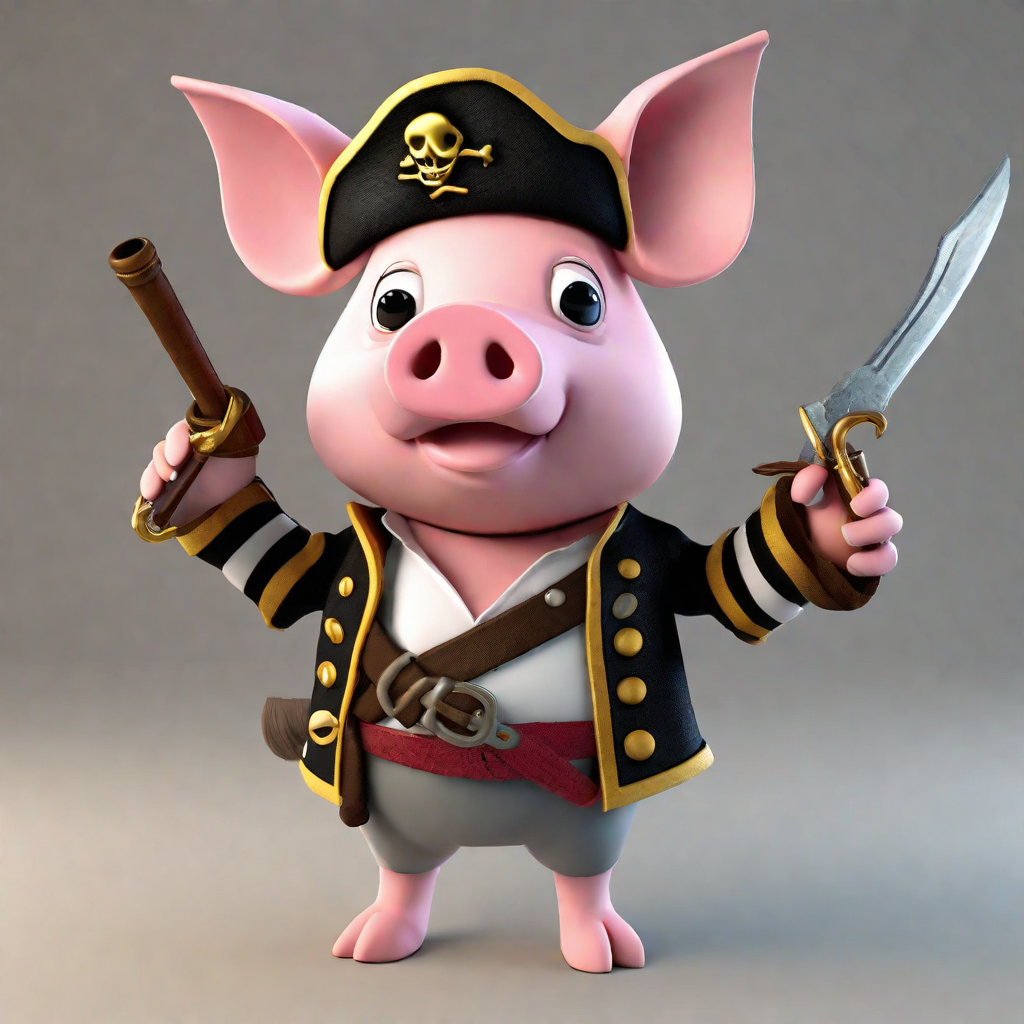

In [9]:
# Generating a reference image using SDXL (for example)
generator = torch.Generator(device='cuda').manual_seed(1)
pipeline_args = {
    "prompt": "A photo of a 3D pirate pig cartoon",
    "generator": generator,
    "num_inference_steps": 25,
    "guidance_scale": 6.0,
}
pig_im = sd_pipeline(**pipeline_args).images[0]
pig_im

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

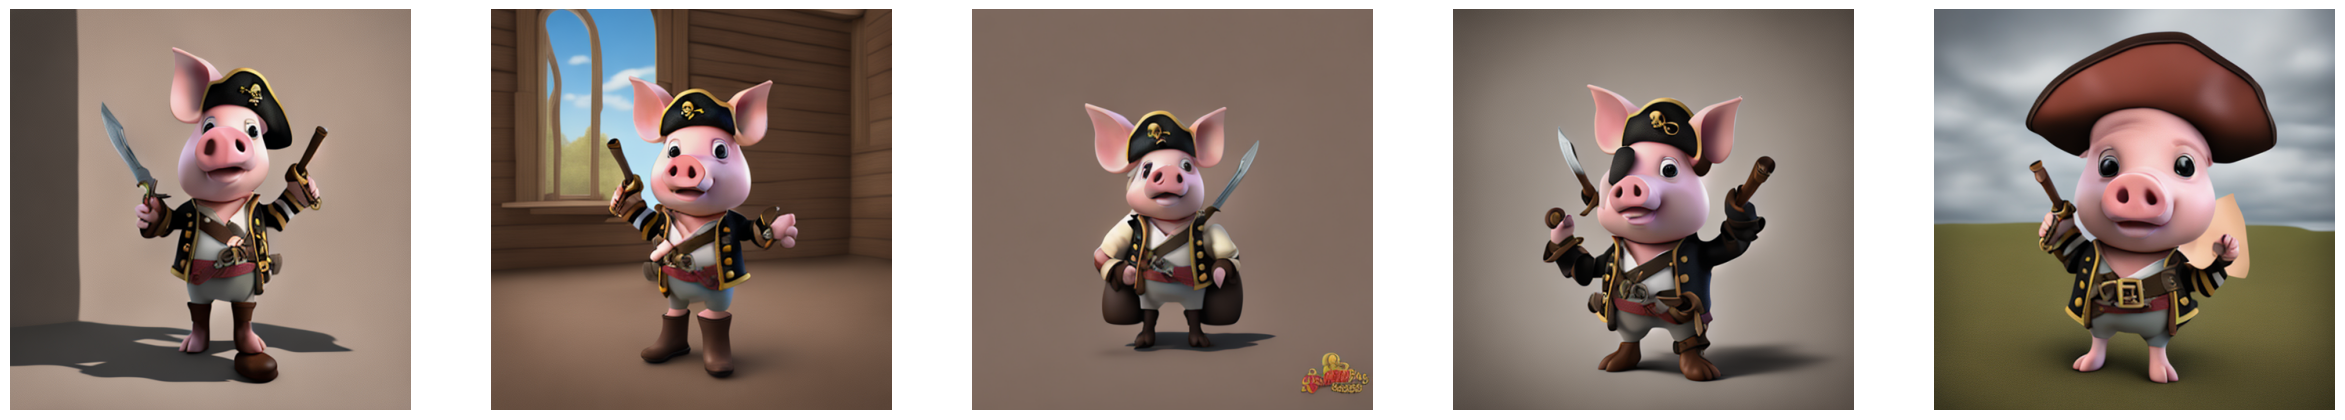

In [10]:
# Remove background and use as reference
im3 = bg_transform(pig_im)
# Generate images using 5 different seeds
ims = gen_five_ims(pipeline, im3, prompt="a photo of a 3D pirate pig cartoon, wearing dark brown boots",
            ref_prompt="a photo of a 3D pirate pig cartoon",
            gs=4.0,
            txtim_gs=6.5, num_steps=25)